In [1]:
import numpy as np
from qiskit import QuantumCircuit

In [2]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("II", 2), ("XX", -3), ("YY", 2), ("ZZ", -4)])

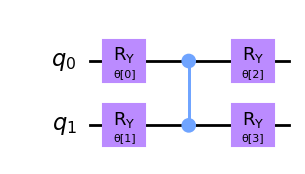

In [3]:
from qiskit.circuit.library import TwoLocal
ansatz = TwoLocal(2, rotation_blocks='ry',
              entanglement_blocks='cz', entanglement='linear',
              reps=1, insert_barriers=False)

ansatz.decompose().draw('mpl', fold=-1, style='clifford')

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
import os

IBM_KEY = os.getenv("IBM_API_KEY")

#Select the least busy backend:

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='yonsei-dedicated/internal/ybscandid',
    #instance='ibm-q/open/main',
    token=IBM_KEY
)

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

C:\Users\Jeongbin\AppData\Local\Temp\ipykernel_25708\3250198410.py:12: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout=isa_ansatz.layout)

In [ ]:
from scipy.stats.qmc import Sobol
import numpy as np

dim = ansatz.num_parameters  
qubits = ansatz.num_qubits  
n_samples = (4**dim) 

sobol = Sobol(d=dim, scramble=True)
params = sobol.random(n=n_samples)
params = -np.pi + 2 * np.pi * params  # [-pi, pi] 범위로 변환
print(params.shape)
print(dim)

(256, 4)
4


In [7]:
estimator_options = EstimatorOptions(
    #resilience_level=1, # not need for real backend
    default_shots=10000
)

batch_size = 2
job_id_list = []
cost_list = []

with Session(backend=backend_sim) as session:
    estimator = Estimator(mode=session, options=estimator_options)
    for i in range(0, n_samples, batch_size):
        batch_params = params[i:i + batch_size]
        #if len(batch_params) < batch_size:
        #    continue  # Skip if the last batch is not full
        inputs = [(isa_ansatz, isa_observable, [params]) for params in batch_params]
        estimator_job = estimator.run(inputs)
        if session._backend.configuration().simulator:
            estimator_results = estimator_job.result()
            for cost in estimator_results:
                cost_list.append(cost.data.evs[0])
        job_id_list.append(estimator_job.job_id())
        print(f"Submitted batch ({i // batch_size + 1} / {n_samples // batch_size}):")
        print(f"\tjob ID: {estimator_job.job_id()}")
        if session._backend.configuration().simulator:
            print(f"\tCost: {cost_list[i:i + batch_size]}")
        

session.close()

Submitted batch (1 / 128):
	job ID: f44810da-8522-4dbf-a0c7-3feee2484a7a
	Cost: [5.985600000000001, -2.7768]
Submitted batch (2 / 128):
	job ID: 58b6b0e0-09b5-4a2f-8768-e425b545f95f
	Cost: [3.082, 2.217]
Submitted batch (3 / 128):
	job ID: d4f90c43-510c-480e-8c74-d2ae304f96f1
	Cost: [0.9896, -2.4066]
Submitted batch (4 / 128):
	job ID: feffaf45-723f-4eeb-a8c3-0af31dfc5a69
	Cost: [-0.6145999999999998, 1.7376000000000003]
Submitted batch (5 / 128):
	job ID: ce198ab4-d342-4d5e-b445-8f3c34813f6a
	Cost: [5.3302, 1.0242]
Submitted batch (6 / 128):
	job ID: 97dde126-6c33-4363-b3b1-6e248a8083d1
	Cost: [-0.8064, 5.036]
Submitted batch (7 / 128):
	job ID: 1530caed-ad2d-4047-b750-5aa9290bf1f5
	Cost: [-1.7879999999999998, 3.9332000000000003]
Submitted batch (8 / 128):
	job ID: 9116c12c-acb1-4ccc-bc0d-c3e8dbdfe493
	Cost: [2.3446, 3.7862]
Submitted batch (9 / 128):
	job ID: df215f10-746e-4523-b563-0ed5bb5164ad
	Cost: [0.32520000000000016, -2.9269999999999996]
Submitted batch (10 / 128):
	job ID: fc0

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.optimize import minimize

# Step 1: surrogate
gpr = GaussianProcessRegressor().fit(params, cost_list)

# Step 2: surrogate cost
def surrogate_expectation(theta):
    return gpr.predict([theta])[0]


In [ ]:

qsr_cost_history = []

def callback(theta):
    value = surrogate_expectation(theta)
    qsr_cost_history.append(value)
    print(f"Step {len(qsr_cost_history)}: cost = {value:.6f}")

In [10]:
num_params = ansatz.num_parameters
results = []

initial_guesses = [np.eye(num_params)[i] for i in range(num_params)]

for idx, x0 in enumerate(initial_guesses):
    res_qsr = minimize(
        surrogate_expectation, 
        x0, 
        method="L-BFGS-B", 
        options={"maxiter": 1000}, 
        callback=callback, 
        tol=1e-10
    )
    print(res_qsr)
    results.append(res_qsr.fun)

Step 1: cost = -1.380925
Step 2: cost = -2.130536
Step 3: cost = -3.623402
Step 4: cost = -4.357375
Step 5: cost = -4.646245
Step 6: cost = -4.923405
Step 7: cost = -5.038465
Step 8: cost = -5.074843
Step 9: cost = -5.216287
Step 10: cost = -5.261171
Step 11: cost = -5.290853
Step 12: cost = -5.295281
Step 13: cost = -5.295414
Step 14: cost = -5.295424
Step 15: cost = -5.295425
Step 16: cost = -5.295425
Step 17: cost = -5.295425
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -5.295425310931181
        x: [ 1.618e+00 -1.776e+00 -9.513e-01  5.738e-01]
      nit: 17
      jac: [ 1.776e-07  1.776e-07  2.665e-07  3.553e-07]
     nfev: 105
     njev: 21
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
Step 18: cost = -1.266672
Step 19: cost = -2.307636
Step 20: cost = -4.465321
Step 21: cost = -4.628429
Step 22: cost = -4.904666
Step 23: cost = -4.981424
Step 24: cost = -4.986117
Step 25: cost = -4.986296
Step 26: cost = -4.9863


[Optimization Summary]
fun      : -5.295425310931176
x        : [ 1.61763  -1.775904 -0.951326  0.573789]
nfev     : 105
message  : CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success  : True


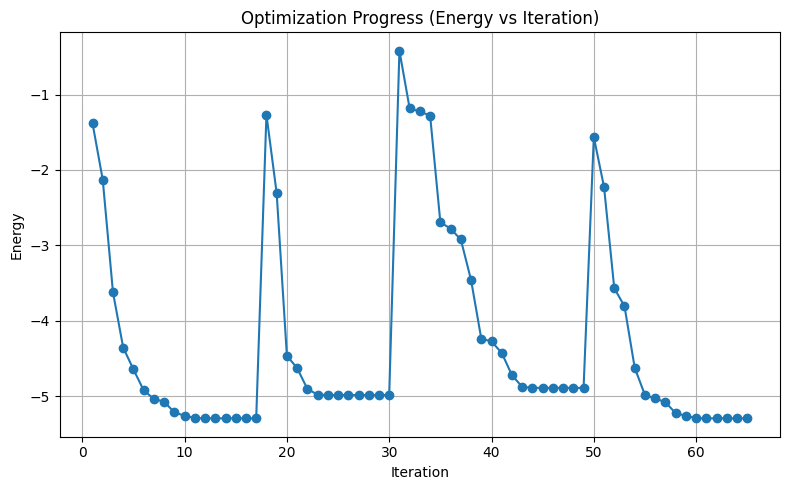

In [11]:
import matplotlib.pyplot as plt
# -------------------------
# 8. 결과 요약
# -------------------------
print("\n[Optimization Summary]")
print("fun      :", res_qsr.fun)
print("x        :", np.round(res_qsr.x, 6))
print("nfev     :", res_qsr.nfev)
print("message  :", res_qsr.message)
print("success  :", res_qsr.success)

# -------------------------
# 9. 최적화 과정 시각화
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(qsr_cost_history) + 1), qsr_cost_history, marker='o')
plt.title("Optimization Progress (Energy vs Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True)
plt.tight_layout()
plt.show()
